# Linear regression from scratch

Powerful ML libraries can eliminate repetitive work, but if you rely too much on abstractions, you might never learn how neural networks really work under the hood. So for this first example, let's get our hands dirty and build everything from scratch, relying only on Numpy. 

In [1]:
from __future__ import print_function
import numpy as np

## Linear regression


To get our feet wet, we'll start off by looking at the problem of regression.
This is the task of predicting a *real valued target* $y$ given a data point $x$.
In linear regression, the simplest and still perhaps the most useful approach,
we assume that prediction can be expressed as a *linear* combination of the input features 
(thus giving the name *linear* regression):

$$\hat{y} = w_1 \cdot x_1 + ... + w_d \cdot x_d + b$$


Given a collection of data points $X$, and corresponding target values $\boldsymbol{y}$, 
we'll try to find the *weight* vector $\boldsymbol{w}$ and bias term $b$ 
(also called an *offset* or *intercept*)
that approximately associate data points $\boldsymbol{x}_i$ with their corresponding labels $\boldsymbol{y}_i$. 
Using slightly more advanced math notation, we can express the predictions $\boldsymbol{\hat{y}}$
corresponding to a collection of datapoints $X$ via the matrix-vector product:

$$\boldsymbol{\hat{y}} = X \boldsymbol{w} + b$$


Before we can get going, we will need two more things 

* Some way to measure the quality of the current model  
* Some way to manipulate the model to improve its quality


### Square loss
In order to say whether we've done a good job, 
we need some way to measure the quality of a model. 
Generally, we will define a *loss function*
that says *how far* are our predictions from the correct answers.
For the classical case of linear regression, 
we usually focus on the squared error.
Specifically, our loss will be the sum, over all examples, of the squared error $(y_i-\hat{y})^2)$ on each:

$$\ell(y, \hat{y}) = \sum_{i=1}^n (\hat{y}_i-y_i)^2.$$


For one-dimensional data, we can easily visualize the relationship between our single feature and the target variable. It's also easy to visualize a linear predictor and it's error on each example. 
Note that squared loss *heavily penalizes outliers*. For the visualized predictor below, the lone outlier would contribute most of the loss.

![](../img/linear-regression.png)


### Manipulating the model

For us to minimize the error,
we need some mechanism to alter the model.
We do this by choosing values of the *parameters*
$\boldsymbol{w}$ and $b$.
This is the only job of the learning algorithm.
Take training data ($X$, $y$) and the functional form of the model $\hat{y} = X\boldsymbol{w} + b$.
Learning then consists of choosing the best possible $\boldsymbol{w}$ and $b$ based on the available evidence.





### Historical note

You might reasonably point out that linear regression is a classical statistical model.
[According to Wikipedia](https://en.wikipedia.org/wiki/Regression_analysis#History), 
Legendre first developed the method of least squares regression in 1805,
which was shortly thereafter rediscovered by Gauss in 1809. 
Presumably, Legendre, who had Tweeted about the paper several times,
was peeved that Gauss failed to cite his arXiv preprint. 

![Legendre](../img/legendre.jpeg)


Matters of provenance aside, you might wonder - if Legendre and Gauss 
worked on linear regression, does that mean there were the original deep learning researchers?
And if linear regression doesn't wholly belong to deep learning, 
then why are we presenting a linear model 
as the first example in a tutorial series on neural networks? 
Well it turns out that we can express linear regression 
as the simplest possible (useful) neural network. 
A neural network is just a collection of nodes (aka neurons) connected by directed edges. 
In most networks, we arrange the nodes into layers with each feeding its output into the layer above. 
To calculate the value of any node, we first perform a weighted sum of the inputs (according to weights ``w``) 
and then apply an *activation function*. 
For linear regression, we only have two layers, one corresponding to the input (depicted in orange) 
and a one-node layer (depicted in green) correspnding to the ouput.
For the output node the activation function is just the identity function.

![](../img/onelayer.png)

While you certainly don't have to view linear regression through the lens of deep learning, 
you can (and we will!).
To ground the concepts that we just discussed in code, 
let's actually code up a neural network for linear regression from scratch.


To get going, we will generate a simple synthetic dataset by sampling random data points ``X[i]`` and corresponding labels ``y[i]`` in the following manner. Our inputs will each be sampled from a random normal distribution with mean $0$ and variance $1$. Our features will be independent. Another way of saying this is that they will have diagonal covariance.  The labels will be generated accoding to the *true* labeling function `y[i] = 2 * X[i][0]- 3.4 * X[i][1] + 4.2 + noise` where the noise is drawn from a random gaussian with mean ``0`` and variance ``.01``. We could express the labeling function in mathematical notation as:
$$y = X \cdot w + b + \eta, \quad \text{for } \eta \sim \mathcal{N}(0,\sigma^2)$$ 

In [2]:
num_inputs = 2
num_outputs = 1
num_examples = 10000
input_mean = [0, 0]
input_variance = [[1, 0],[0, 1]]
noise_mean = 0
noise_variance = 0.01

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2
    
X = np.random.multivariate_normal(input_mean, input_variance, num_examples)
X /= np.max(X)
noise = np.random.normal(noise_mean, noise_variance, num_examples)
y = real_fn(X) + noise

Notice that each row in ``X`` consists of a 2-dimensional data point and that each row in ``Y`` consists of a 1-dimensional target value. 

In [3]:
print(X[0])
print(y[0])

[ 0.24470042  0.22835131]
3.91519102645


a linear combination with the (known) optimal parameters 
produces a prediction that is indeed close to the target value where the random noise brings the difference.

In [4]:
print(2 * X[0, 0] - 3.4 * X[0, 1] + 4.2)

3.913006397


We can visualize the correspondence between our second feature (``X[:, 1]``) and the target values ``Y`` by generating a scatter plot with the Python plotting package ``matplotlib``. Make sure that ``matplotlib`` is installed. Otherwise, you may install it by running ``pip2 install matplotlib`` (for Python 2) or ``pip3 install matplotlib`` (for Python 3) on your command line. 

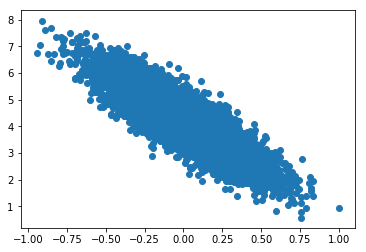

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1], y)
plt.show()

## Data iterators

Once we start working with neural networks, we're going to need to iterate through our data points quickly. In BigDL, we fully utilize the convenient and friendly funcationalities of Spark's RDD, allowing users to transform their original ``nd_array``-type features-label pairs into Spark RDDs by using a simple function ``to_sample_rdd``. The ``to_sample_rdd`` has another ``num_Slices`` parameter which indicates the number of partitions you want for the result RDD. With specification, its default value equals the number of CPU cores currently used. You can use `sc.defaultParallelism` to check it programmatically or just simply find it in the start script for the `spark-submit` job.

In [6]:
from bigdl.util.common import *
rdd = to_sample_rdd(X, y)

In [7]:
print(sc.defaultParallelism)
rdd.getNumPartitions()

4


4

As [Spark's rdd programming guide](https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html#parallelized-collections) suggests, typically you want 2-4 partitions for each CPU in your cluster. So, let's reset the partition number to 8.

In [8]:
rdd = to_sample_rdd(X, y, 8)
rdd.getNumPartitions()

8

Once the data is transformed into RDD, you can access the powerful methods of RDD to inspect more easily on your data. You can even customize your methods and chain them together to unleash more information about the training inputs. To give you a hint to better understand the usage, the following code will print the features and labels pair by pair under the new format in the terminal.

In [9]:
def printFeatureLabelPairs(record):
        print('features: '+str(record.features)+' label: '+str(record.label))
rdd.foreach(printFeatureLabelPairs)

## Model parameters

Now let's allocate some memory for our parameters and set their initial values randomly from the Guassian ditribution. 

In [10]:
w = np.random.multivariate_normal(input_mean, input_variance, num_examples)
b = np.random.normal(0, 1, num_examples)
params = [w, b]

In the succeeding cells, we're going to update these parameters to better fit our data. This will involve taking the gradient (a multi-dimensional derivative) of some *loss function* with respect to the parameters. We'll update each parameter in the direction that reduces the loss.

## Neural networks

Next we'll want to define our model. In this case, we'll be working with linear models, the simplest possible *useful* neural network. To calculate the output of the linear model, we simply multiply a given input with the model's weights (``w``), and add the offset ``b``.

In [27]:
def net(X):
    return w.dot(X.transpose()) + b

Ok, that was easy.

## Loss function

Train a model means making it better and better over the course of a period of training. But in order for this goal to make any sense at all, we first need to define what *better* means in the first place. In this case, we'll use the squared distance between our prediction and the true value. 

In [28]:
def square_loss(yhat, y): 
    return np.mean((yhat - y) ** 2)

## Optimizer

It turns out that linear regression actually has a closed-form solution. However, most interesting models that we'll care about cannot be solved analytically. So we'll solve this problem by stochastic gradient descent. At each step, we'll estimate the gradient of the loss with respect to our weights. Then, we'll update our parameters a small amount in the direction that reduces the loss. The size of the step is determined by the *learning rate* ``lr``. 

In [29]:
def get_gradient(w, x, y):
    y_estimate = net(x)
    error = y - y_estimate
    gradient = -(1.0/len(x)) * error.dot(x)
    loss= square_loss(y, y_estimate)
    return gradient, loss

In [30]:
lr = 1
tolerance = 1e-3

# Perform Gradient Descent
epochs = 1
while True:
    gradient, loss = get_gradient(w, X, y)
    new_w = w - lr * gradient
    
    # Stopping Condition
    if np.sum(abs(new_w - w)) < tolerance:
        print("Converged.")
        break
    
    # Print error every 50 iterations
    if epochs % 3 == 0:
        print("Iteration: %d - Loss: %.4f" %(epochs, loss))
    
    epochs += 1
    w = new_w
 


Converged.
